# Regularized regression: US county-level sociodemographic and health resource data (2018-2019)

For this project I will attempt to model the prevalence of morbidity at the county level as a function of socioeconomic, demographic and health care related features. The label will be defined as the number of people with any reported medical condition per 100 people in the county.

An initial round of manual feature selection will be used to discard clearly redundant, confounding or unnecessary features before EDA.

Linear regression will be used to model the data, including regularization.

## Notebook set-up

Handle imports of necessary modules up-front.

In [1]:
# Standard library imports
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# Set display options for pandas
pd.set_option('display.max_rows', 100)

## 1. Data loading

### 1.1. Load

In [2]:
data_url = 'https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv'
data_df = pd.read_csv(data_url, sep=',')

### 1.2. Save local copy

In [3]:
Path('../data/raw').mkdir(parents=True, exist_ok=True)
data_df.to_parquet('../data/raw/demographic_health_data.parquet', index=False)

### 1.3. Inspect

In [4]:
data_df.head().transpose()

,0,1,2,3,4
fips,1001,1003,1005,1007,1009
TOT_POP,55601,218022,24881,22400,57840
0-9,6787,24757,2732,2456,7095
0-9 y/o % of total pop,12.206615,11.355276,10.980266,10.964286,12.266598
19-Oct,7637,26913,2960,2596,7570
...,...,...,...,...,...
CKD_prevalence,3.1,3.2,4.5,3.3,3.4
CKD_Lower 95% CI,2.9,3.0,4.2,3.1,3.2
CKD_Upper 95% CI,3.3,3.5,4.8,3.6,3.7
CKD_number,1326,5479,887,595,1507


In [5]:
data_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 108 columns):
 #    Column                                                                         Non-Null Count  Dtype  
---   ------                                                                         --------------  -----  
 0    fips                                                                           3140 non-null   int64  
 1    TOT_POP                                                                        3140 non-null   int64  
 2    0-9                                                                            3140 non-null   int64  
 3    0-9 y/o % of total pop                                                         3140 non-null   float64
 4    19-Oct                                                                         3140 non-null   int64  
 5    10-19 y/o % of total pop                                                       3140 non-null   float64
 6    20-29         

## 2. Initial feature selection

In [6]:
# Our label is the rate of any condition per 100 people
label = data_df['anycondition_number'] / (data_df['TOT_POP'] / 100)

### 2.1. Age features

In [7]:
# Select age-related features
age_features = data_df.columns[2:20]
age_df = data_df[age_features].copy()

# Remove age count features, keeping only percentages
feature_drops = age_df.filter(regex = '^\d+-\d+$').columns
age_df.drop(columns=feature_drops, inplace=True)
age_df.drop(columns=['19-Oct', '80+'], inplace=True)

age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   0-9 y/o % of total pop    3140 non-null   float64
 1   10-19 y/o % of total pop  3140 non-null   float64
 2   20-29 y/o % of total pop  3140 non-null   float64
 3   30-39 y/o % of total pop  3140 non-null   float64
 4   40-49 y/o % of total pop  3140 non-null   float64
 5   50-59 y/o % of total pop  3140 non-null   float64
 6   60-69 y/o % of total pop  3140 non-null   float64
 7   70-79 y/o % of total pop  3140 non-null   float64
 8   80+ y/o % of total pop    3140 non-null   float64
dtypes: float64(9)
memory usage: 220.9 KB


### 2.2. Ethnicity features

In [8]:
# Select Ethnicity-related features
ethnicity_features = data_df.columns[20:32]
ethnicity_df = data_df[ethnicity_features].copy()

# Remove count features, keeping only percentages
features = ethnicity_df.filter(regex = '^\%').columns
ethnicity_df = ethnicity_df[features]

ethnicity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   % White-alone        3140 non-null   float64
 1   % Black-alone        3140 non-null   float64
 2   % NA/AI-alone        3140 non-null   float64
 3   % Asian-alone        3140 non-null   float64
 4   % Hawaiian/PI-alone  3140 non-null   float64
 5   % Two or more races  3140 non-null   float64
dtypes: float64(6)
memory usage: 147.3 KB


### 2.3. Population features

In [9]:
population_features = ['TOT_POP', 'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'R_birth_2018', 'R_death_2018']
population_df = data_df[population_features].copy()
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TOT_POP            3140 non-null   int64  
 1   POP_ESTIMATE_2018  3140 non-null   int64  
 2   N_POP_CHG_2018     3140 non-null   int64  
 3   R_birth_2018       3140 non-null   float64
 4   R_death_2018       3140 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 122.8 KB


### 2.4. Education features

In [10]:
education_features = data_df.columns[45:49]
education_df = data_df[education_features].copy()
education_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 4 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Percent of adults with less than a high school diploma 2014-18           3140 non-null   float64
 1   Percent of adults with a high school diploma only 2014-18                3140 non-null   float64
 2   Percent of adults completing some college or associate's degree 2014-18  3140 non-null   float64
 3   Percent of adults with a bachelor's degree or higher 2014-18             3140 non-null   float64
dtypes: float64(4)
memory usage: 98.3 KB


### 2.5. Employment features

In [11]:
employment_features = data_df.columns[56:62]
employment_df = data_df[employment_features].copy()
employment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 6 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Civilian_labor_force_2018                  3140 non-null   int64  
 1   Employed_2018                              3140 non-null   int64  
 2   Unemployed_2018                            3140 non-null   int64  
 3   Unemployment_rate_2018                     3140 non-null   float64
 4   Median_Household_Income_2018               3140 non-null   int64  
 5   Med_HH_Income_Percent_of_State_Total_2018  3140 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 147.3 KB


### 2.6. Healthcare access features

In [12]:
healthcare_features = data_df.columns[62:75]
healthcare_df = data_df[healthcare_features].copy()
healthcare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 13 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Active Physicians per 100000 Population 2018 (AAMC)                            3140 non-null   float64
 1   Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)         3140 non-null   float64
 2   Active Primary Care Physicians per 100000 Population 2018 (AAMC)               3140 non-null   float64
 3   Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)  3140 non-null   float64
 4   Active General Surgeons per 100000 Population 2018 (AAMC)                      3140 non-null   float64
 5   Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)         3140 non-null   float64
 6   Total nurse practitioner

### 2.7. Other

In [13]:
other_features = data_df.columns[78:82]
other_df = data_df[other_features].copy()
other_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   COUNTY_NAME  3140 non-null   object
 1   STATE_NAME   3140 non-null   object
 2   STATE_FIPS   3140 non-null   int64 
 3   CNTY_FIPS    3140 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 98.3+ KB


### 2.8. Re-combine selected features

In [14]:
data_df = pd.concat([age_df,ethnicity_df,population_df,education_df,employment_df,healthcare_df,other_df], axis=1)
data_df['morbidity'] = label

# Rename features with shorter, more plot-friendly names
column_renames = {
    # Age features (percentages)
 
    '0-9 y/o % of total pop': 'pct_0-9',
    '10-19 y/o % of total pop': 'pct_10-19',
    '20-29 y/o % of total pop': 'pct_20-29',
    '30-39 y/o % of total pop': 'pct_30-39',
    '40-49 y/o % of total pop': 'pct_40-49',
    '50-59 y/o % of total pop': 'pct_50-59',
    '60-69 y/o % of total pop': 'pct_60-69',
    '70-79 y/o % of total pop': 'pct_70-79',
    '80+ y/o % of total pop': 'pct_80+',
    
    # Ethnicity features
    '% Not Hispanic or Latino': 'pct_non_hispanic',
    '% Hispanic or Latino': 'pct_hispanic',
    '% American Indian and Alaska Native Alone': 'pct_native_american',
    '% Asian Alone': 'pct_asian',
    '% Black or African American Alone': 'pct_black',
    '% Native Hawaiian and Other Pacific Islander Alone': 'pct_pacific_islander',
    '% Two or More Races': 'pct_multiracial',
    '% White Alone': 'pct_white',
    
    # Population features
    'TOT_POP': 'total_population',
    'POP_ESTIMATE_2018': 'pop_estimate_2018',
    'N_POP_CHG_2018': 'pop_change_2018',
    'R_birth_2018': 'birth_rate_2018',
    'R_death_2018': 'death_rate_2018',
    
    # Education features
    'Percent of adults with less than a high school diploma 2014-18': 'pct_no_hs_diploma',
    'Percent of adults with a high school diploma only 2014-18': 'pct_hs_only',
    'Percent of adults completing some college or associate\'s degree 2014-18': 'pct_some_college',
    'Percent of adults with a bachelor\'s degree or higher 2014-18': 'pct_bachelor_plus',
    
    # Employment features
    'Civilian_labor_force_2018': 'civilian_labor_force',
    'Employed_2018': 'employed_2018',
    'Unemployed_2018': 'unemployed_2018',
    'Unemployment_rate_2018': 'unemployment_rate',
    'Median_Household_Income_2018': 'median_household_income',
    'Med_HH_Income_Percent_of_State_Total_2018': 'income_pct_of_state',
    
    # Healthcare access features
    'Active Physicians per 100000 Population 2018 (AAMC)': 'active_physicians_per_100k',
    'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)': 'primary_physicians_per_100k',
    'Active Primary Care Physicians per 100000 Population 2018 (AAMC)': 'active_primary_care_per_100k',
    'Active General Surgeons per 100000 Population 2018 (AAMC)': 'general_surgeons_per_100k',
    'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)': 'surgeons_per_100k',
    'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)': 'total_physicians_per_100k',
    'Total nurse practitioners (2019)': 'total_nurse_practitioners',
    'Total physician assistants (2019)': 'total_physician_assistants',
    'Total Hospitals (2019)': 'total_hospitals',
    'Internal Medicine Primary Care (2019)': 'internal_medicine_physicians',
    'Family Medicine/General Practice Primary Care (2019)': 'family_medicine_physicians',
    'Total Specialist Physicians (2019)': 'total_specialist_physicians',
}

data_df.rename(columns=column_renames, inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pct_0-9                       3140 non-null   float64
 1   pct_10-19                     3140 non-null   float64
 2   pct_20-29                     3140 non-null   float64
 3   pct_30-39                     3140 non-null   float64
 4   pct_40-49                     3140 non-null   float64
 5   pct_50-59                     3140 non-null   float64
 6   pct_60-69                     3140 non-null   float64
 7   pct_70-79                     3140 non-null   float64
 8   pct_80+                       3140 non-null   float64
 9   % White-alone                 3140 non-null   float64
 10  % Black-alone                 3140 non-null   float64
 11  % NA/AI-alone                 3140 non-null   float64
 12  % Asian-alone                 3140 non-null   float64
 13  % H

## 3. EDA
### 3.1. Data composition

#### 3.1.1. Categorical features

In [15]:
print(f"Unique county names: {data_df['COUNTY_NAME'].nunique()}\n")
data_df['COUNTY_NAME'].value_counts().head(10)

Unique county names: 1841



COUNTY_NAME
Washington    31
Jefferson     26
Lincoln       24
Franklin      24
Jackson       24
Madison       20
Montgomery    18
Union         18
Clay          18
Monroe        17
Name: count, dtype: int64

In [16]:
print(f"Unique state names: {data_df['STATE_NAME'].nunique()}\n")
data_df['STATE_NAME'].value_counts().head(10)

Unique state names: 51



STATE_NAME
Texas             254
Georgia           159
Virginia          133
Kentucky          120
Missouri          115
Kansas            105
Illinois          102
North Carolina    100
Iowa               99
Tennessee          95
Name: count, dtype: int64

#### 3.1.2. Ratio features

In [17]:
ratio_features = data_df.select_dtypes(include=[np.number]).columns.tolist()
ratio_features.remove('STATE_FIPS')
ratio_features.remove('CNTY_FIPS')
ratio_features.remove('morbidity')
data_df[ratio_features].describe()

,pct_0-9,pct_10-19,pct_20-29,pct_30-39,pct_40-49,pct_50-59,pct_60-69,pct_70-79,pct_80+,% White-alone,...,primary_physicians_per_100k,general_surgeons_per_100k,surgeons_per_100k,total_nurse_practitioners,total_physician_assistants,total_hospitals,internal_medicine_physicians,family_medicine_physicians,total_specialist_physicians,ICU Beds_x
count,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,...,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000,3140.000000
mean,11.871051,12.694609,12.283979,11.751535,11.556685,13.526733,13.182225,8.399382,4.733801,84.494109,...,80.074045,7.621943,6.775159,52.698009,28.215940,1.655299,62.898806,44.393892,167.332629,23.817516
std,2.124081,1.815044,3.126297,1.696599,1.372935,1.481692,2.532498,2.214915,1.535028,16.348987,...,10.487697,1.288832,1.126812,153.878850,86.409281,4.293436,214.737693,133.348667,543.035916,84.602028
min,0.000000,0.000000,0.000000,6.092789,2.631579,5.316361,3.444403,2.199551,0.000000,3.841985,...,61.200000,5.600000,5.000000,0.025524,0.009726,0.001363,0.046773,0.030356,0.111759,0.000000
25%,10.594639,11.674504,10.496774,10.689322,10.685197,12.738561,11.621232,7.032275,3.738648,79.620473,...,72.900000,6.900000,6.100000,5.439135,2.475921,0.248797,4.843825,5.312558,14.740077,0.000000
50%,11.802727,12.687422,11.772649,11.580861,11.618372,13.621339,13.013409,8.208162,4.565338,91.410189,...,79.000000,7.100000,6.500000,13.076544,5.969606,0.524404,12.386405,12.153987,36.223582,0.000000
75%,12.951840,13.659282,13.182260,12.639379,12.386083,14.429115,14.467254,9.445777,5.484143,95.521727,...,87.200000,8.300000,7.200000,35.215580,18.598497,1.311585,36.902489,31.312501,103.869345,12.000000
max,25.460677,23.304372,37.570198,22.225129,19.430369,20.454545,27.272727,31.327959,22.727273,99.043785,...,179.400000,25.300000,15.200000,3937.767709,2022.531916,91.712638,5713.007608,3882.586846,15014.048660,2126.000000


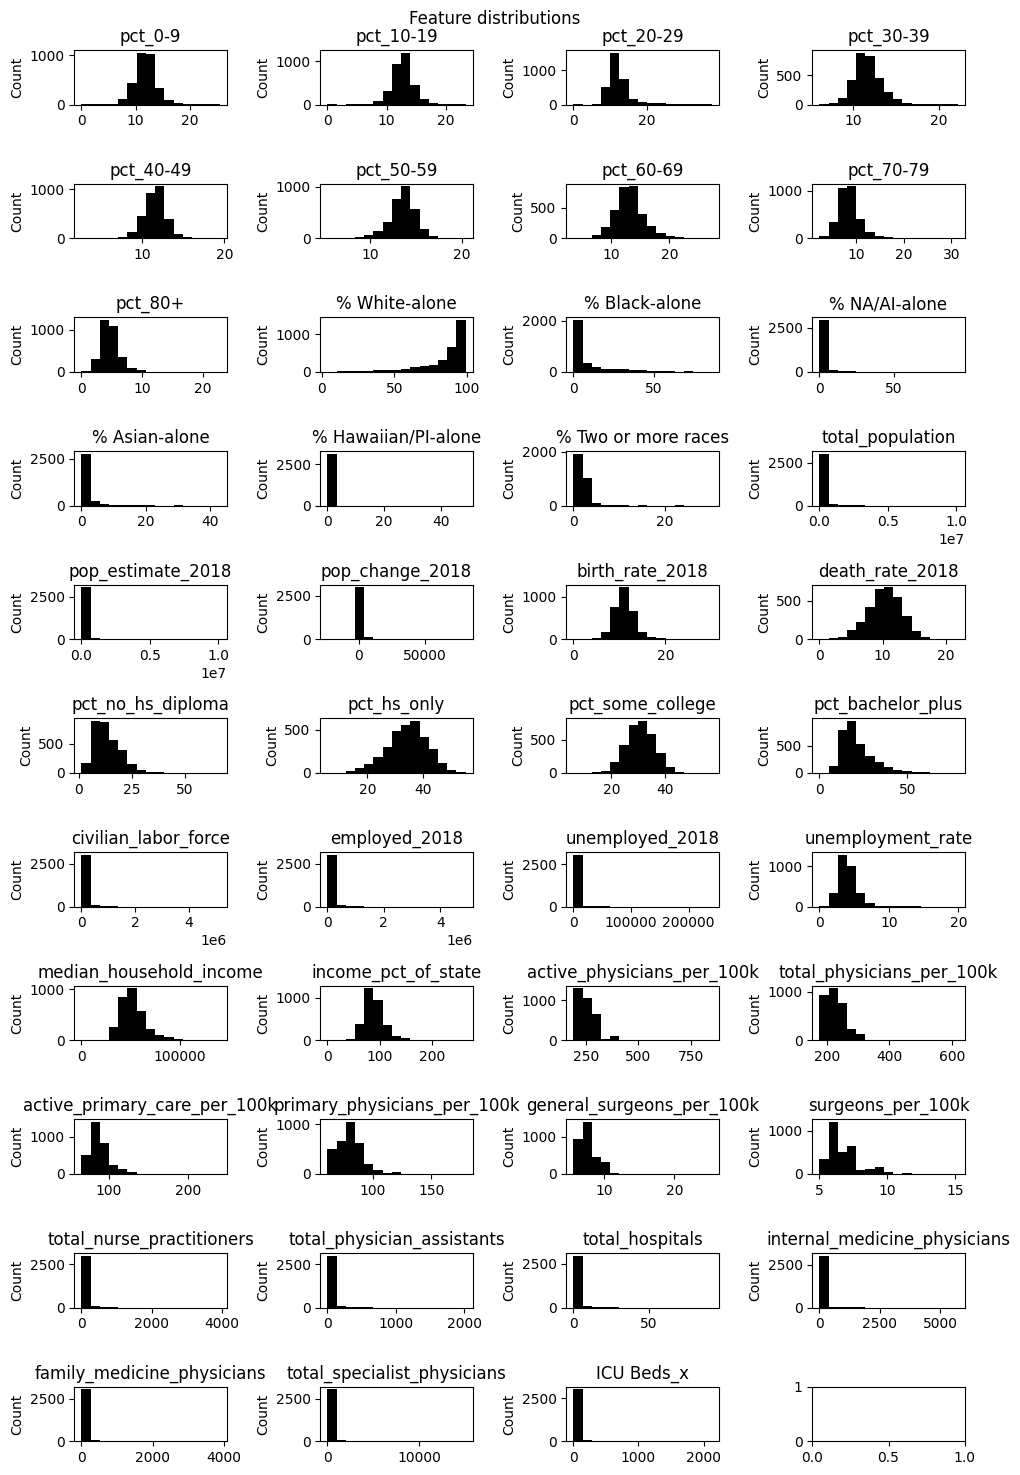

In [18]:
fig, axs = plt.subplots(11,4, figsize=(10,15))
axs = axs.flatten()

fig.suptitle('Feature distributions')

for i, feature in enumerate(ratio_features):
    axs[i].set_title(feature)
    axs[i].hist(data_df[feature], color='black', bins=15)
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

#### 3.1.3. Label

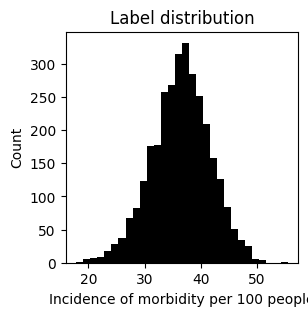

In [19]:
plt.figure(figsize=(3, 3))
plt.title('Label distribution')
plt.hist(data_df['morbidity'], bins=30, color='black')
plt.xlabel('Incidence of morbidity per 100 people')
plt.ylabel('Count')
plt.show()

### 3.2. Feature-label correlations

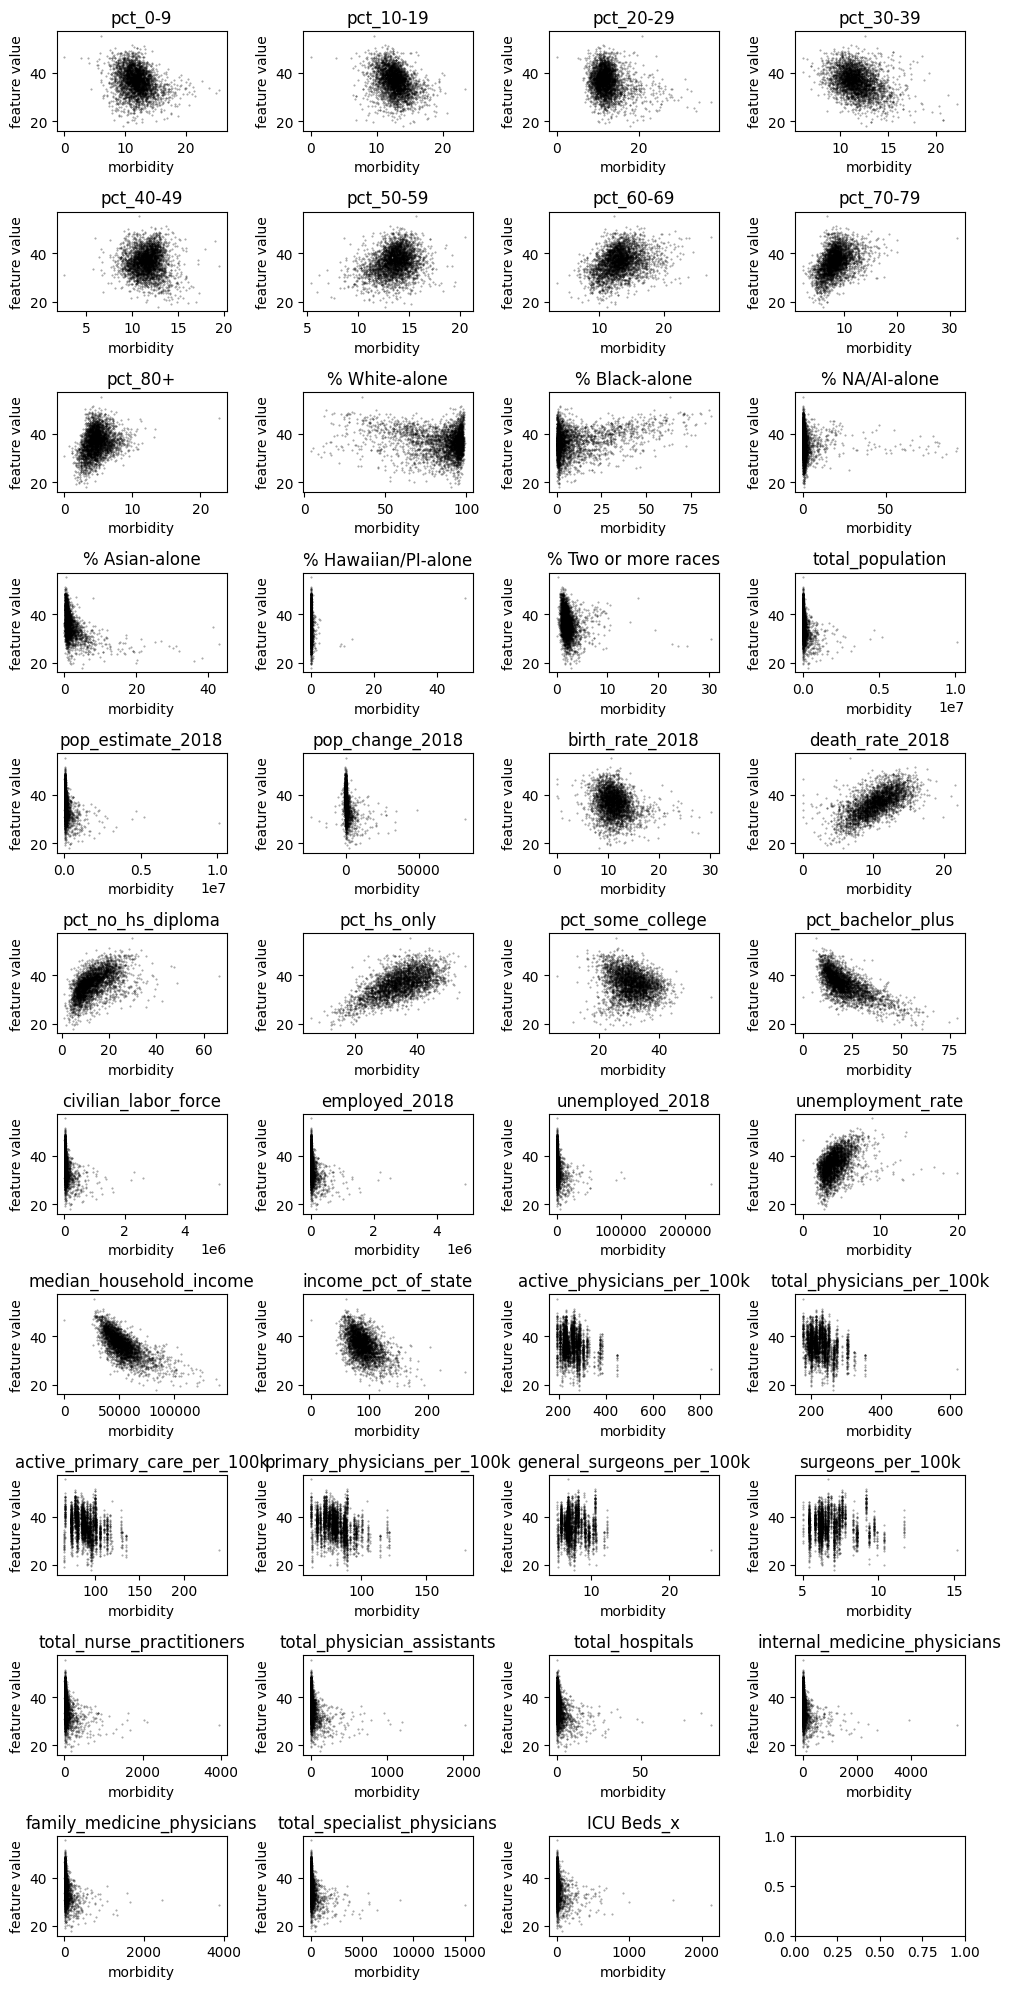

In [20]:
fig, axs = plt.subplots(11, 4, figsize=(10,20))
axs = axs.flatten()

for i, feature in enumerate(ratio_features):
    axs[i].set_title(feature)
    axs[i].scatter(data_df[feature], data_df['morbidity'], s=0.2, color='black', alpha=0.4)
    axs[i].set_xlabel('morbidity')
    axs[i].set_ylabel('feature value')

plt.tight_layout()
plt.show()

## 4. Data preparation

### 4.1. Train-test split

In [21]:
training_df, testing_df = train_test_split(
    data_df,
    test_size=0.2
)

### 4.2. Feature encoding

In [22]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
training_df[['COUNTY_NAME', 'STATE_NAME']] = encoder.fit_transform(training_df[['COUNTY_NAME', 'STATE_NAME']])
testing_df[['COUNTY_NAME', 'STATE_NAME']] = encoder.transform(testing_df[['COUNTY_NAME', 'STATE_NAME']])

### 4.3. Interaction features

In [23]:
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
poly_transformer.fit(training_df.drop(columns=['morbidity']))
poly_training_features = poly_transformer.transform(training_df.drop(columns=['morbidity']))
poly_testing_features = poly_transformer.transform(testing_df.drop(columns=['morbidity']))

poly_training_df = pd.DataFrame(poly_training_features, columns=poly_transformer.get_feature_names_out())
poly_testing_df = pd.DataFrame(poly_testing_features, columns=poly_transformer.get_feature_names_out())

poly_training_df['morbidity'] = training_df['morbidity'].values
poly_testing_df['morbidity'] = testing_df['morbidity'].values

## 5. Linear model training

### 5.1. Baseline

In [24]:
mean_prevalence = poly_training_df['morbidity'].mean()
rmse = root_mean_squared_error(poly_testing_df['morbidity'],[mean_prevalence]*len(poly_testing_df))
rsq = r2_score(poly_testing_df['morbidity'],[mean_prevalence]*len(poly_testing_df))

print(f'Mean cost model RMSE: {rmse:.2f}')
print(f'Mean cost model R squared: {rsq:.2f}')

Mean cost model RMSE: 5.21
Mean cost model R squared: -0.00


In [25]:
model = LinearRegression()
model.fit(poly_training_df.drop(columns=['morbidity']), poly_training_df['morbidity'])

training_predictions = model.predict(poly_training_df.drop(columns=['morbidity']))
training_labels = poly_training_df['morbidity']

train_rmse = root_mean_squared_error(training_labels, training_predictions)
train_rsq = r2_score(training_labels, training_predictions)

testing_predictions = model.predict(poly_testing_df.drop(columns=['morbidity']))
testing_labels = poly_testing_df['morbidity']

test_rmse = root_mean_squared_error(testing_labels, testing_predictions)
test_rsq = r2_score(testing_labels, testing_predictions)

print(f'Linear model training RMSE: {train_rmse:.2f}')
print(f'Linear model testing RMSE: {test_rmse:.2f}\n')
print(f'Linear model training squared: {train_rsq:.2f}')
print(f'Linear model testing squared: {test_rsq:.2f}')

Linear model training RMSE: 1.51
Linear model testing RMSE: 36.39

Linear model training squared: 0.91
Linear model testing squared: -47.73


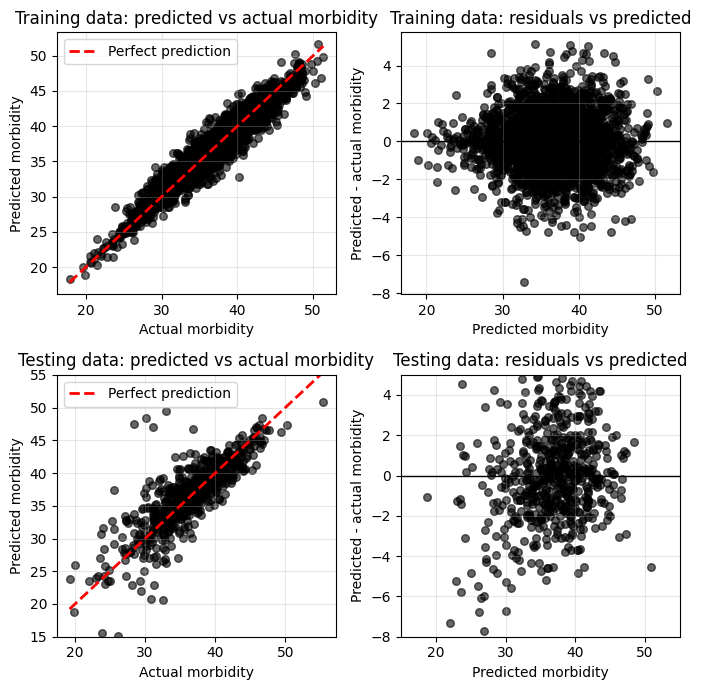

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs = axs.flatten()

# Training predicted vs Actual plot
axs[0].scatter(training_labels, training_predictions, color='black', alpha=0.6, s=30)
axs[0].plot([min(training_labels), max(training_labels)], [min(training_labels), max(training_labels)], 
            'r--', linewidth=2, label='Perfect prediction')
axs[0].set_xlabel('Actual morbidity')
axs[0].set_ylabel('Predicted morbidity')
axs[0].set_title(f'Training data: predicted vs actual morbidity')
axs[0].legend()
axs[0].grid(alpha=0.3)

# Training residuals plot
residuals = training_predictions - training_labels
axs[1].scatter(training_predictions, residuals, color='black', alpha=0.6, s=30)
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[1].set_xlabel('Predicted morbidity')
axs[1].set_ylabel('Predicted - actual morbidity')
axs[1].set_title(f'Training data: residuals vs predicted')
axs[1].grid(alpha=0.3)

# Testing predicted vs Actual plot
axs[2].scatter(testing_labels, testing_predictions, color='black', alpha=0.6, s=30)
axs[2].plot([min(testing_labels), max(testing_labels)], [min(testing_labels), max(testing_labels)], 
            'r--', linewidth=2, label='Perfect prediction')
axs[2].set_xlabel('Actual morbidity')
axs[2].set_ylabel('Predicted morbidity')
axs[2].set_title(f'Testing data: predicted vs actual morbidity')
axs[2].set_ylim([15,55])
axs[2].legend()
axs[2].grid(alpha=0.3)

# testing residuals plot
residuals = testing_predictions - testing_labels
axs[3].scatter(testing_predictions, residuals, color='black', alpha=0.6, s=30)
axs[3].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[3].set_xlabel('Predicted morbidity')
axs[3].set_ylabel('Predicted - actual morbidity')
axs[3].set_title(f'Testing data: residuals vs predicted')
axs[3].set_ylim([-8,5])
axs[3].set_xlim([15,55])
axs[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Model regularization

In [ ]:
%%time

penalties=[0.0000125, 0.000025, 0.00005, 0.0001, 0.0002, 0.0004, 0.0008, 0.0016, 0.0032, 0.0064, 0.0128, 0.0256, 0.1024, 0.2048]
train_rmse_values=[]
test_rmse_values=[]

for penalty in penalties:
    lasso_model=Lasso(alpha=penalty, max_iter=5000)
    result=lasso_model.fit(training_features, training_labels)

    train_predictions=lasso_model.predict(training_features)
    train_rmse=root_mean_squared_error(training_labels, train_predictions)
    train_rmse_values.append(train_rmse)

    test_predictions=lasso_model.predict(testing_features)
    test_rmse=root_mean_squared_error(testing_labels, test_predictions)
    test_rmse_values.append(test_rmse)

    print(f'Prediction RMSE: training: {train_rmse:.4f}, testing: {test_rmse:.4f}')

print()

In [ ]:
plt.title('Regression RMSE vs L1 penalty')
plt.plot(penalties, train_rmse_values, color='black', label='Training')
plt.plot(penalties, test_rmse_values, color='red', label='Testing')
plt.xlabel('L1 penalty')
plt.xscale('log', base=2)
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

## 5. Hyperparameter optimization

In [ ]:
%%time

penalties=[1, 10, 100, 1000, 10000]
train_rmse_values=[]
test_rmse_values=[]

for penalty in penalties:
    ridge_model=Ridge(alpha=penalty, max_iter=5000)
    result=ridge_model.fit(training_features, training_labels)

    train_predictions=ridge_model.predict(training_features)
    train_rmse=root_mean_squared_error(training_labels, train_predictions)
    train_rmse_values.append(train_rmse)

    test_predictions=ridge_model.predict(testing_features)
    test_rmse=root_mean_squared_error(testing_labels, test_predictions)
    test_rmse_values.append(test_rmse)

    print(f'Prediction RMSE: training: {train_rmse:.4f}, testing: {test_rmse:.4f}')

print()

In [ ]:
plt.title('Regression RMSE vs L1 penalty')
plt.plot(penalties, train_rmse_values, color='black', label='Training')
plt.plot(penalties, test_rmse_values, color='red', label='Testing')
plt.xlabel('L1 penalty')
plt.xscale('log', base=2)
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

## 6. Final model evaluation

In [ ]:
lasso_model=Lasso(alpha=2**-9.7, max_iter=5000)
result=lasso_model.fit(training_features, training_labels)

train_predictions=lasso_model.predict(training_features)
train_rmse=root_mean_squared_error(training_labels, train_predictions)

test_predictions=lasso_model.predict(testing_features)
test_rmse=root_mean_squared_error(testing_labels, test_predictions)

print(f'Prediction RMSE: training: {train_rmse:.4f}, testing: {test_rmse:.4f}')